In [1]:
# -*- coding: utf-8 -*-
from __future__ import division
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms as transforms
import pandas as pd
import os
import pydicom
import numpy as np
import glob
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.color import gray2rgb
import functools
import seaborn as sns
import scipy
import PIL
import json


In [2]:

data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection-265-jpeg/'
#data_dir = '/scratch/rsna-str-pulmonary-embolism-detection-265-jpeg/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'

In [4]:
df = pd.read_csv(train_csv)

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6cc79b883538,57e3520a9db2,d07a9d2101f1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
996,6cc79b883538,57e3520a9db2,5bd03ffe234d,0,1,0,0,0,0,0,0,0,0,0,0,0,0
997,6cc79b883538,57e3520a9db2,64e347674c91,0,1,0,0,0,0,0,0,0,0,0,0,0,0
998,6cc79b883538,57e3520a9db2,ce4549f13d59,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
len(df.StudyInstanceUID.unique())

7279

In [8]:
len(df.SeriesInstanceUID.unique())

7279

In [30]:
studies = df.StudyInstanceUID.unique()
negative = 0
positive = 0
studyID = ''

for index, row in df.iterrows():
    i = row['StudyInstanceUID']
    if i != studyID:
        studyID = i
        if int(row['negative_exam_for_pe']) == 0:
            positive += 1
        else:
            negative += 1
    

In [31]:
negative

4911

In [32]:
positive

2368

In [33]:
len(studies)

7279

In [52]:
studies[2009]

'1a5a8dc58c79'

In [55]:
dff = df[df['StudyInstanceUID'] == '1a5a8dc58c79']

In [56]:
len(list(dff['pe_present_on_image']))

181

In [51]:
studies = df.StudyInstanceUID.unique()

In [9]:
import numpy as np

filename = '6897fa9de148.npy'

with open(filename, 'rb') as f:
    a = np.load(f)
    
a

array([[[25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        ...,
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25]],

       [[25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        ...,
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25]],

       [[25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        ...,
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25]],

       ...,

       [[25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        ...,
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25, 25],
        [25, 25, 25, ..., 25, 25

In [2]:
import seaborn as sns

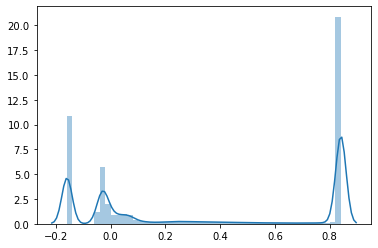

In [4]:
sns.distplot(a.flatten())

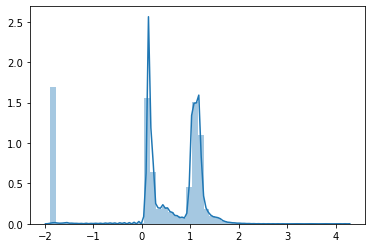

In [6]:
sns.distplot(a.flatten())

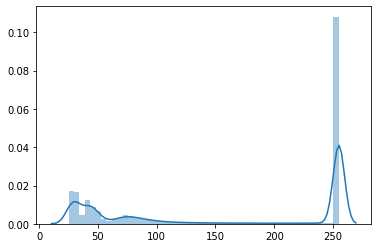

In [10]:
sns.distplot(a.flatten())